In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
import pandas as pd
import seaborn as sns

In [46]:
def run_experiment(
    n_trials_per_condition=100,
    n_images=6, 
    match_coh=0.02, 
    nonmatch_coh=-0.02,
    method='seq',
    **drift_diffusion_kwargs
):
    """Runs a mental navigation experiment

    Args:
        n_trials_per_condition (int, optional): Number of trials to run per 
            condition. Defaults to 100.
        n_images (int, optional): Number of images in sequence. Defaults to 6.
        method (string, optional): Function for iterating through images to 
            simulate. Defaults to 'seq' (sequential)
        match_coh (float, optional): Coherence of match stimulus. Defaults to 
            0.02
        nonmatch_coh (float, optional): Coherence of nonmatch stimulus. Defaults
            to -0.02
    """
    conditions = list(permutations(np.arange(n_images), 2))
    results = []
    if method == 'seq':
        f = seq_trial
    elif method == 'simul':
        f = simul_trial
    for (start_image, target_image) in conditions:
        results += [f(start_image=start_image, 
                target_image=target_image, 
                n_images=n_images,
                match_coh=match_coh,
                nonmatch_coh=nonmatch_coh,
                **drift_diffusion_kwargs) for _ in range(n_trials_per_condition)]
    return results


def simul_trial(
    start_image, 
    target_image, 
    n_images,
    match_coh=0.02,
    nonmatch_coh=-0.02,
   **drift_diffusion_kwargs,

):
    """Simulates a mental navigation trial in simultaneous mode. Simulates in
    both directions at once until an edge or a wall is hit. 

    Args:
        start_image (int): Index of starting image.
        target_image (int): Index of target image.
        n_images (int): Number of images in sequence
        match_coh (float, optional): Coherence of match stimulus.
            Defaults to 0.02.
        nonmatch_coh (float, optional): Coherence of nonmatch stimulus.
            Defaults to -0.02.
    """

    match = False
    terminate = False
    total_reaction_time = 0
    results = []
    directions = np.array([1, -1])
    current_image = start_image + directions
    n_iter = 0
    cohs = np.array([nonmatch_coh, match_coh ])
    while not (match or terminate):
        if np.any(current_image >= n_images) or np.any(current_image < 0):
            terminate = True
        else:
            n_iter += 1

            coh_0 = int(current_image[0] == target_image) 
            coh_0 = cohs[coh_0]
            coh_1 = int(current_image[1] == target_image)
            coh_1 = cohs[coh_1]  
            dd_results_0 = _drift_diffusion(coh_0, **drift_diffusion_kwargs) 
            dd_results_1 = _drift_diffusion(coh_1, **drift_diffusion_kwargs)
            trial_reaction_time = np.amax((dd_results_0['reaction_time'],
                dd_results_1['reaction_time']))
            if dd_results_0['match']:
                match = True
                trial_reaction_time = dd_results_0['reaction_time']
            elif dd_results_1['match']:
                match = True
                trial_reaction_time = dd_results_1['reaction_time']
            results.append([dd_results_0, dd_results_1])
            total_reaction_time += trial_reaction_time
            if match:
                return dict(
                    condition=(start_image, target_image),
                    results=results,
                    total_reaction_time=total_reaction_time,
                    match=True,
                    n_iter=n_iter
                )

            current_image = current_image + directions
    return dict(
        condition=(start_image, target_image),
        results=results,
        match=False,
        total_reaction_time=total_reaction_time,
        n_iter=n_iter

    )

        

def seq_trial(
    start_image,
    target_image,
    n_images, 
    match_coh=0.02,
    nonmatch_coh=-0.02,
    **drift_diffusion_kwargs
):
    """Simulates a mental navigation trial in sequential mode. Randomly selects
    direction, simulates from the starting image in that direction until match
    or edge is reached, at which point direction is switched

    Args:
        start_image (int): Index of starting image
        target_image (int): Index of target image
        n_images (int): Number of images in sequence        
        match_coh (float, optional): Coherence of match stimulus. Defaults to 
            0.02
        nonmatch_coh (float, optional): Coherence of nonmatch stimulus. Defaults
            to -0.02
    """
    

    match = False    
    total_reaction_time = 0
    results = []
    direction = np.random.choice([-1, 1])
    terminate = False
    current_image = start_image + direction
    while not (match or terminate):
        if current_image >= n_images or current_image < 0:
            terminate = True
        else:
            if current_image == target_image:
                coh = match_coh
            else:
                coh = nonmatch_coh
            dd_results = _drift_diffusion(coh, **drift_diffusion_kwargs)
            total_reaction_time += dd_results['reaction_time']
            match = dd_results['match']
            results.append(dd_results)
            if match:
                return dict(
                    condition=(start_image, target_image),
                    results=results,
                    total_reaction_time=total_reaction_time,
                    match=True
                )
            current_image = current_image + direction
    return dict(
        condition=(start_image, target_image),
        results=results,
        match=False,
        total_reaction_time=total_reaction_time
    )


def _drift_diffusion(
    coh,
    k=0.2,
    a=1.0,
    z=0.5,
    max_n_samples=1000
    ):
    """Simulates drift diffusion process.

    Args:
        coh (float): Stimulus coherence. 
        k (float): Coefficient applied to stimulus coherence to obtain drift 
            rate. Defaults to 1.0.
        a (float): Upper boundary. Lower boundary is 0.
            Defaults to 1.0.
        z (float): Starting point of diffusion process. Defaults to 0.5.
        max_n_samples (int): Maximum number of samples to draw before process   
            terminates. Defaults to 1000.
    """
    samples = np.zeros((max_n_samples + 1, 1))
    dv = np.zeros((max_n_samples + 1, 1)) 
    dv[0] = z
    terminated = False
    match = None
    for t in range(max_n_samples):
        samples[t] = np.random.normal(loc=k * coh, scale=0.01) 
        dv[t+1] = dv[t] + samples[t]
        if dv[t+1] >= a or dv[t+1] <= 0:
            terminated = True
            match = dv[t+1] >= a
            break
    reaction_time = None
    if terminated:
        match = match
        reaction_time = t
        dv = dv[:t+1]
        samples = samples[:t+1]
    return dict(
        samples=samples,
        terminated=terminated,
        trace=dv,
        reaction_time=reaction_time,
        match=match,
        coh=coh,
        k=k, 
        a=a,
        z=z,
    )

def _plot_drift_diffusion(samples, trace, a, k, z, coh, **kwargs):
    """Plot samples and evidence for drift diffusion process

    Args:
        samples (np.array): Samples taken for process
        trace (np.array): Decision variable array
        k (float): Slope coefficient. 
        a (float): Upper boundary. 
        z (float): Starting point of diffusion process.
        coh (float): Stimulus coherence.
    """
    f, axs = plt.subplots(2, 1, sharex=True, dpi=100)
    axs[0].plot(samples)
    axs[0].set_ylabel('evidence')
    axs[1].plot(trace)
    axs[1].set_xlabel('timestep')
    axs[1].set_ylabel('decision variables')
    axs[1].axhline(a, linestyle='--', color='red')
    axs[1].axhline(0, linestyle='--', color='red')
    axs[1].axhline(z, linestyle='--', color='black')
    axs[0].set_title(f'k={k}, a={a}, z={z}, coh={coh}')
    plt.show()





# Simultaneous model

In [57]:
results = run_experiment(method='simul', n_images=9) 
results = pd.DataFrame(results) 
results['start_image'] = [condition[0] for condition in results.condition]
results['target_image'] = [condition[1] for condition in results.condition]
results['abs_distance'] = [np.abs(condition[1] - condition[0]) 
    for condition in results.condition]
results['distance'] = [condition[1] - condition[0] 
    for condition in results.condition]


In [58]:
total_reaction_time_by_condition = \
    results.groupby(['start_image', 'target_image'])['total_reaction_time'].mean().to_frame().reset_index()
total_reaction_time_by_condition = total_reaction_time_by_condition.pivot(index='start_image', columns='target_image')
total_reaction_time_by_distance = results.groupby('abs_distance')['total_reaction_time'].mean()

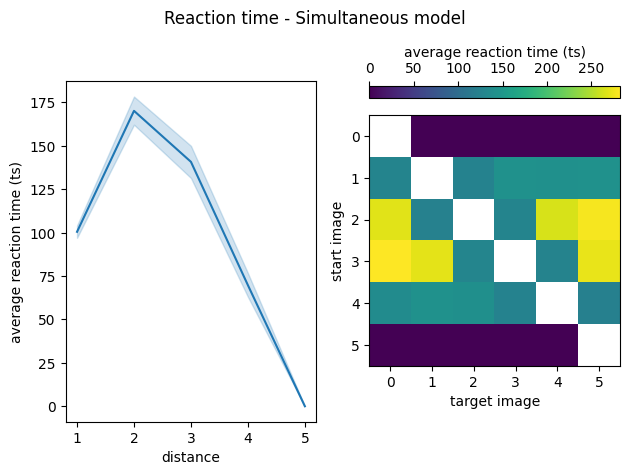

In [59]:
f, axs = plt.subplots(1, 2, dpi=100)
im = axs[1].imshow(total_reaction_time_by_condition)
axs[1].set_xlabel('target image')
axs[1].set_ylabel('start image')
f.colorbar(im, fraction=0.05, location='top', 
label='average reaction time (ts)')

f.suptitle('Reaction time - Simultaneous model')

sns.lineplot(data=results, x='abs_distance', y='total_reaction_time', ax=axs[0])
axs[0].set_ylabel('average reaction time (ts)')
axs[0].set_xlabel('distance')

plt.tight_layout()
plt.show()

# Sequential model 

In [245]:
results = run_experiment()
print(len(results))
results = pd.DataFrame(results) 
results['start_image'] = [condition[0] for condition in results.condition]
results['target_image'] = [condition[1] for condition in results.condition]
results['distance'] = [np.abs(condition[1] - condition[0]) 
    for condition in results.condition]


3000
1499


In [218]:
total_reaction_time_by_condition = \
    results.groupby(['start_image', 'target_image'])['total_reaction_time'].mean().to_frame().reset_index()
total_reaction_time_by_condition = total_reaction_time_by_condition.pivot(index='start_image', columns='target_image')
total_reaction_time_by_distance = results.groupby('distance')['total_reaction_time'].mean()

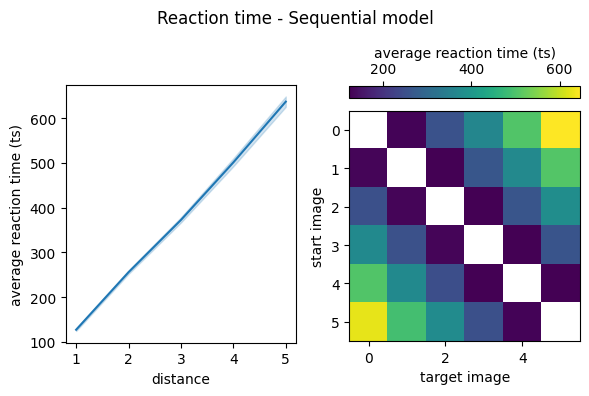

In [219]:
f, axs = plt.subplots(1, 2, dpi=100)
im = axs[1].imshow(total_reaction_time_by_condition)
axs[1].set_xlabel('target image')
axs[1].set_ylabel('start image')
f.colorbar(im, fraction=0.05, location='top', 
label='average reaction time (ts)')

f.suptitle('Reaction time - Sequential model')

sns.lineplot(data=results, x='distance', y='total_reaction_time', ax=axs[0])
axs[0].set_ylabel('average reaction time (ts)')

plt.tight_layout()
plt.show()